In [17]:
import pandas as pd
import numpy as np
import requests
import requests_cache
requests_cache.install_cache('demo_cache', expire_after=86400, allowable_methods=['GET', 'POST'])
import matplotlib.pyplot as plt
import time

In [8]:
# Importing data
df = pd.read_csv('unk_ids/df2_artist_rec_names_artist_list.txt')

# MAKE SURE TO DROP NAN ROWS OR THE CODE WILL CRASH
df.dropna(subset = ['MLHD_rec_name', 'MLHD_artist_name'], inplace=True)

df.head()

,timestamp,mlhd_artist_mbid,mlhd_recording_mbid,canonical_mbid,MLHD_rec_name,MLHD_artist_name,artist_credit_list
0,1108412731,f4a31f0a-51dd-4fa7-986d-3095c40c5ed9,1deb956c-5439-4fbb-b026-5adb4330a934,1deb956c-5439-4fbb-b026-5adb4330a934,Anywhere,Evanescence,f4a31f0a-51dd-4fa7-986d-3095c40c5ed9
1,1108422818,db999c3f-f243-4a5f-88d6-0c25243b6661,14e9eb4e-155d-46ff-9a83-a8d5e1936c81,b0e80c50-6bca-415c-9515-1b4983329b80,Lady Lady,Mark Joseph,db999c3f-f243-4a5f-88d6-0c25243b6661
2,1108423325,ce58d854-7430-4231-aa44-97f0144b3372,eced9a9b-cd59-40f8-a580-f27094bd8a89,6ae8e64a-d208-4f4e-8d88-155ed0568344,Building a Mystery,Sarah McLachlan,ce58d854-7430-4231-aa44-97f0144b3372
3,1108594566,e6e879c0-3d56-4f12-b3c5-3ce459661a8e,0a8e9fce-b54c-45dd-8081-4aaa654ef4ec,da1308d1-6037-4ba1-b6fc-a643a4201140,Hallelujah,Jeff Buckley,e6e879c0-3d56-4f12-b3c5-3ce459661a8e
4,1108679759,3c0a0074-4f26-4d3b-b723-a66bf6cc3753,06a5b648-0950-4892-a975-715291a5de6f,a2a800b4-4969-4bc6-88e9-6928b973890c,Penny & Me,Hanson,3c0a0074-4f26-4d3b-b723-a66bf6cc3753


# Mapping for first 1000 MBIDs with chunk-size = 10

1. Get Chunk of data
2. Make Payload
3. Get Mapping
4. Join with DataFrame on arg_name / recording_name
5. Loop over again.

In [9]:
# test_df = df.loc[:50, ['MLHD_artist_name', 'MLHD_rec_name']]
test_df = df.loc[:50]
test_df.head()

,timestamp,mlhd_artist_mbid,mlhd_recording_mbid,canonical_mbid,MLHD_rec_name,MLHD_artist_name,artist_credit_list
0,1108412731,f4a31f0a-51dd-4fa7-986d-3095c40c5ed9,1deb956c-5439-4fbb-b026-5adb4330a934,1deb956c-5439-4fbb-b026-5adb4330a934,Anywhere,Evanescence,f4a31f0a-51dd-4fa7-986d-3095c40c5ed9
1,1108422818,db999c3f-f243-4a5f-88d6-0c25243b6661,14e9eb4e-155d-46ff-9a83-a8d5e1936c81,b0e80c50-6bca-415c-9515-1b4983329b80,Lady Lady,Mark Joseph,db999c3f-f243-4a5f-88d6-0c25243b6661
2,1108423325,ce58d854-7430-4231-aa44-97f0144b3372,eced9a9b-cd59-40f8-a580-f27094bd8a89,6ae8e64a-d208-4f4e-8d88-155ed0568344,Building a Mystery,Sarah McLachlan,ce58d854-7430-4231-aa44-97f0144b3372
3,1108594566,e6e879c0-3d56-4f12-b3c5-3ce459661a8e,0a8e9fce-b54c-45dd-8081-4aaa654ef4ec,da1308d1-6037-4ba1-b6fc-a643a4201140,Hallelujah,Jeff Buckley,e6e879c0-3d56-4f12-b3c5-3ce459661a8e
4,1108679759,3c0a0074-4f26-4d3b-b723-a66bf6cc3753,06a5b648-0950-4892-a975-715291a5de6f,a2a800b4-4969-4bc6-88e9-6928b973890c,Penny & Me,Hanson,3c0a0074-4f26-4d3b-b723-a66bf6cc3753


In [25]:
def make_payload(series_artist_name, series_rec_name):
    payload = []
    for artist_name, rec_name in zip(series_artist_name.to_list(), series_rec_name.to_list()):
    # for artist_name, rec_name in zip(series_artist_name, series_rec_name):
        json_inp = dict()
        json_inp["[artist_credit_name]"] = artist_name
        json_inp["[recording_name]"] = rec_name
        payload.append(json_inp)
    return payload

# make_payload(df.MLHD_rec_name[:1], df.MLHD_artist_name[:1])

In [26]:
def gen_chunk(df, chunksize=15):
    for i in range(0, len(df), chunksize):
        yield df[i:i+chunksize]

In [27]:
def get_mapping(df):
    base_url = "https://labs.api.listenbrainz.org/mbid-mapping/json"
    series_artist, series_rec = df.MLHD_artist_name, df.MLHD_rec_name
    payload = make_payload(series_artist, series_rec)

    r = requests.post(base_url, json = payload)
    try:
        return r.json()
    except:
        return "[{}]"

# Tests
# get_mapping(df[:2])
# get_mapping(pd.DataFrame([('audgsf', 'jdshfl')], columns=['MLHD_artist_name', 'MLHD_rec_name']))
# get_mapping(pd.DataFrame([('audgsf', 'jdshfl'), ('eminem', 'godzilla')], columns=['MLHD_artist_name', 'MLHD_rec_name']))

In [28]:
def get_mapping_rec(json_reply_list):
    # json_reply_list = json_reply_list.json()
    mapping_rec = []
    if json_reply_list is not None:
        for json_reply in json_reply_list:
            mapping_rec.append([json_reply['artist_credit_arg'], json_reply['recording_arg'], json_reply['recording_mbid']])
    
    return mapping_rec

# #Test

# ls = []
# for chunk in gen:
#     ls.append(get_mapping(chunk))

# temp = []
# for item in ls:
#     temp = [*temp, *item]

# temp

In [52]:
def result_processor(df, replies):
    return df.join(pd.DataFrame(replies).set_index([0,1]).rename(columns={2: 'received_rec_mbid'}), on=['MLHD_artist_name', 'MLHD_rec_name'])

def get_replies(df):
    replies = []
    for chunk in gen_chunk(df, 15):
        reply = get_mapping_rec(get_mapping(chunk))
        replies = [*replies, *reply]
        time.sleep(0.5)
    return replies

# Testing
# x = map_processor(test_df)
# x.head()

In [56]:
%%time
inp = df[:10000]
repl = get_replies(inp)
final_mapping = result_processor(inp, repl)
final_mapping.to_csv('unk_ids/final_mapping.csv', index=False)

CPU times: user 12.5 s, sys: 1.03 s, total: 13.5 s
Wall time: 18min 19s


In [55]:
final_mapping.head()

,timestamp,mlhd_artist_mbid,mlhd_recording_mbid,canonical_mbid,MLHD_rec_name,MLHD_artist_name,artist_credit_list,received_rec_mbid
0,1108412731,f4a31f0a-51dd-4fa7-986d-3095c40c5ed9,1deb956c-5439-4fbb-b026-5adb4330a934,1deb956c-5439-4fbb-b026-5adb4330a934,Anywhere,Evanescence,f4a31f0a-51dd-4fa7-986d-3095c40c5ed9,1deb956c-5439-4fbb-b026-5adb4330a934
1,1108422818,db999c3f-f243-4a5f-88d6-0c25243b6661,14e9eb4e-155d-46ff-9a83-a8d5e1936c81,b0e80c50-6bca-415c-9515-1b4983329b80,Lady Lady,Mark Joseph,db999c3f-f243-4a5f-88d6-0c25243b6661,b0e80c50-6bca-415c-9515-1b4983329b80
2,1108423325,ce58d854-7430-4231-aa44-97f0144b3372,eced9a9b-cd59-40f8-a580-f27094bd8a89,6ae8e64a-d208-4f4e-8d88-155ed0568344,Building a Mystery,Sarah McLachlan,ce58d854-7430-4231-aa44-97f0144b3372,6ae8e64a-d208-4f4e-8d88-155ed0568344
3,1108594566,e6e879c0-3d56-4f12-b3c5-3ce459661a8e,0a8e9fce-b54c-45dd-8081-4aaa654ef4ec,da1308d1-6037-4ba1-b6fc-a643a4201140,Hallelujah,Jeff Buckley,e6e879c0-3d56-4f12-b3c5-3ce459661a8e,da1308d1-6037-4ba1-b6fc-a643a4201140
4,1108679759,3c0a0074-4f26-4d3b-b723-a66bf6cc3753,06a5b648-0950-4892-a975-715291a5de6f,a2a800b4-4969-4bc6-88e9-6928b973890c,Penny & Me,Hanson,3c0a0074-4f26-4d3b-b723-a66bf6cc3753,a2a800b4-4969-4bc6-88e9-6928b973890c


# Calculating Optimal Query Size

2.52 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.18 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.07 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.14 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.23 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.01 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.16 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.12 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.09 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)
2.13 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


Text(0, 0.5, 'Time in seconds')

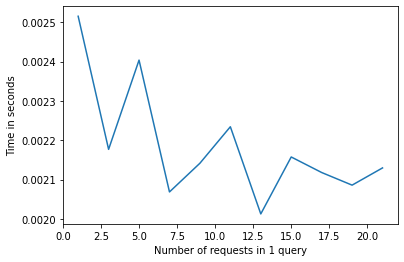

In [32]:
result_dict = {}

for i in range(1, 22, 2):
    result = %timeit -n5 -r1 -o get_mapping(df[:i])
    result_dict[i] = result.average

plt.plot(result_dict.keys(), result_dict.values())
plt.xlabel('Number of requests in 1 query')
plt.ylabel('Time in seconds')

## Testing for missing values

In [81]:
print(f"% of canonical_mbids not in received_rec_mbid: {(final_mapping[-final_mapping.canonical_mbid.isin(final_mapping.received_rec_mbid)].shape[0]/final_mapping.shape[0])*100}")
print(f"% of NaN MBIDs in (% of canonical_mbids in received_rec_mbid): {(final_mapping[-final_mapping.canonical_mbid.isin(final_mapping.received_rec_mbid)].received_rec_mbid.isna().value_counts()[1]/final_mapping[-final_mapping.canonical_mbid.isin(final_mapping.received_rec_mbid)].shape[0])*100}")
print(f"% of unmatched (not NaN) MBIDs in (% of canonical_mbids in received_rec_mbid): {(final_mapping[-final_mapping.canonical_mbid.isin(final_mapping.received_rec_mbid)].received_rec_mbid.isna().value_counts()[0]/final_mapping[-final_mapping.canonical_mbid.isin(final_mapping.received_rec_mbid)].shape[0])*100}")

# final_mapping[-final_mapping.received_rec_mbid.isin(final_mapping.canonical_mbid)]

% of canonical_mbids not in received_rec_mbid: 8.520267611176703
% of NaN MBIDs in (% of canonical_mbids in received_rec_mbid): 61.54734411085451
% of unmatched (not NaN) MBIDs in (% of canonical_mbids in received_rec_mbid): 38.4526558891455


In [84]:
final_mapping[-final_mapping.canonical_mbid.isin(final_mapping.received_rec_mbid)].received_rec_mbid.isna()

5         True
6         True
7         True
8         True
12        True
         ...  
10004     True
10005    False
10007     True
10028    False
10044     True
Name: received_rec_mbid, Length: 866, dtype: bool